In [1]:

import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "data/"

df_train = pd.read_csv(data_path + "df_imputed_train.csv")
df_test = pd.read_csv(data_path + "df_imputed_test.csv")
#data is already normalized

#activate this or not to take in account the lagged values
for i in range(4,19):
    df_train = df_train.drop(columns=f'spot_id_delta_lag_{i}', axis=1)
    df_test = df_test.drop(columns=f'spot_id_delta_lag_{i}', axis=1)

df_train['DELIVERY_START'] = pd.to_datetime(df_train['DELIVERY_START'], utc=True)
df_test['DELIVERY_START'] = pd.to_datetime(df_test['DELIVERY_START'], utc=True)

df_train = df_train.set_index('DELIVERY_START')
df_test = df_test.set_index('DELIVERY_START')

#target variable
y_train_df = pd.read_csv(data_path + "y_train.csv")
y_test_df = pd.read_csv(data_path + "y_test.csv")

y_train_df['DELIVERY_START'] = pd.to_datetime(y_train_df['DELIVERY_START'], utc=True)
y_test_df['DELIVERY_START'] = pd.to_datetime(y_test_df['DELIVERY_START'], utc=True)

y_train_df = y_train_df.set_index('DELIVERY_START')
y_test_df = y_test_df.set_index('DELIVERY_START')

y_train_df = y_train_df[y_train_df.index.isin(df_train.index)]
y_test_df = y_test_df[y_test_df.index.isin(df_test.index)]

In [3]:
pca = PCA(n_components=0.9, random_state=42)
pca.fit(df_train)
df_train_pca = pca.transform(df_train)
df_test_pca = pca.transform(df_test)

In [4]:
# Try different numbers of clusters and compute BIC or silhouette
bic_scores = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_train_pca)
    labels = gmm.predict(df_train_pca)
    
    bic_scores.append(gmm.bic(df_train_pca))
    silhouette_scores.append(silhouette_score(df_train_pca, labels))

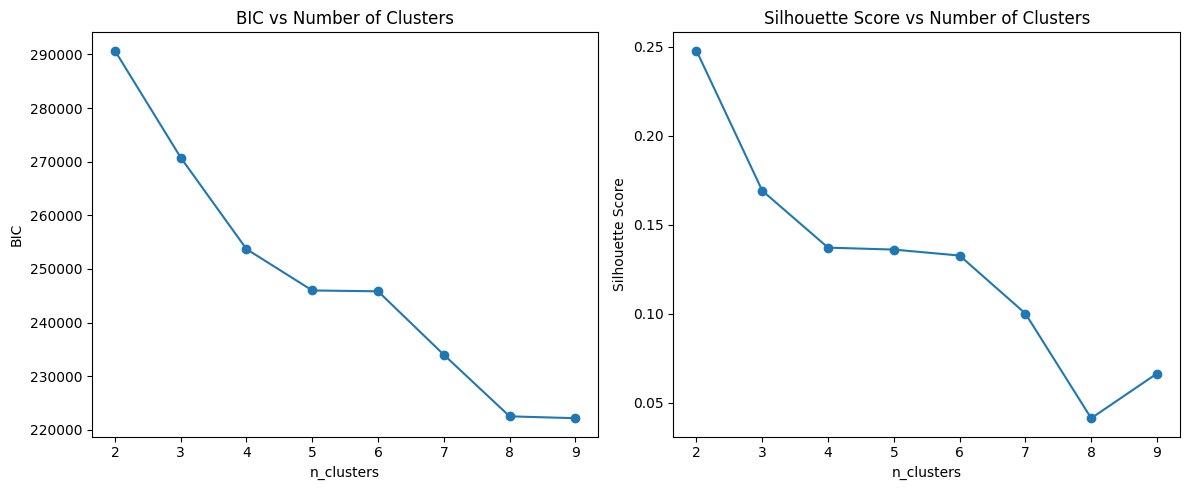

In [5]:
#Plot to help choose optimal K
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_range, bic_scores, marker='o')
plt.title("BIC vs Number of Clusters")
plt.xlabel("n_clusters")
plt.ylabel("BIC")

plt.subplot(1,2,2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

#Interpretation of the results
# The BIC score is a measure of model fit, with lower values indicating a better fit.
# The silhouette score measures how similar an object is to its own cluster compared to other clusters.
# A higher silhouette score indicates better-defined clusters.
"""
BIC Score
BIC decreases sharply from 2 to 5 clusters, then flattens out.

Elbow appears around 5: beyond that, BIC improvement is marginal.

This suggests that 5 clusters could be a good fit without overfitting.

Silhouette Score
Best score is at 2 clusters (~0.32), but:

It drops quickly afterward and stays very low.

Scores < 0.1 suggest poorly separated or overlapping clusters, which can happen in high-dim or continuous utility data.
"""

#In our case, let's choose 5 clusters based on BIC and interpret the results.

n_clusters = 10

In [14]:
# Fit GMM with 5 clusters and visualize the results
# Assign initial labels to GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=42, init_params='kmeans')
gmm.fit(df_train_pca)
labels = gmm.predict(df_train_pca)

# Check cluster sizes and reassign small clusters if necessary
min_cluster_size = 100 
cluster_sizes = np.bincount(labels)
for i in range(n_clusters):
    print(i)
    if cluster_sizes[i] < min_cluster_size:
        
        cluster_points = df_train_pca[labels == i]
        other_clusters = [j for j in range(n_clusters) if j != i]
        distances = np.array([np.linalg.norm(cluster_points - gmm.means_[j], axis=1) for j in other_clusters])
        closest_cluster = other_clusters[np.argmin(distances.mean(axis=1))]
        print(labels[labels == i])
        print(closest_cluster)
        labels[labels == i] = closest_cluster
        

df_train['Cluster'] = labels
df_test['Cluster'] = gmm.predict(df_test_pca)
np.bincount(gmm.predict(df_test_pca))

0
1
2
3
4
5
6
7
8
9


array([  81,   60,    0,  283, 1776, 1498,    3,  771,    0,  470])

In [15]:
# Let's visualize the clusters in 2D using PCA
pca_3d = PCA(n_components=3, random_state=42)
pca_3d.fit(df_train)
df_train_3d = pca_3d.transform(df_train)
df_test_3d = pca_3d.transform(df_test)

fig = px.scatter_3d(
    x=df_train_3d[:, 0],
    y=df_train_3d[:, 1],
    z=df_train_3d[:, 2],
    color=labels,  # You can replace `labels` with any other column or array for coloring
    title="3D PCA of Clusters for training data",
    labels={'x': 'PCA1', 'y': 'PCA2', 'z': 'PCA3'},
    color_discrete_sequence=px.colors.qualitative.Plotly,  # You can replace this with a different color sequence
    opacity=0.7,
)
fig.update_traces(marker=dict(size=3))  # Decrease the size of the points
fig.update_layout(scene=dict(aspectmode='cube', xaxis=dict(title_font=dict(size=15)), yaxis=dict(title_font=dict(size=15)), zaxis=dict(title_font=dict(size=15))), width=1000, height=800)
fig.show()

# Visualize the clusters in 3D for test data

fig = px.scatter_3d(
    x=df_test_3d[:, 0],
    y=df_test_3d[:, 1],
    z=df_test_3d[:, 2],
    color=gmm.predict(df_test_pca),  # You can replace `labels` with any other column or array for coloring
    title="3D PCA of Clusters for testing data",
    labels={'x': 'PCA1', 'y': 'PCA2', 'z': 'PCA3'},
    color_discrete_sequence=px.colors.qualitative.Plotly,  # You can replace this with a different color sequence
    opacity=0.7,
)
fig.update_traces(marker=dict(size=3))  # Decrease the size of the points
fig.update_layout(scene=dict(aspectmode='cube', xaxis=dict(title_font=dict(size=15)), yaxis=dict(title_font=dict(size=15)), zaxis=dict(title_font=dict(size=15))), width=1000, height=800)
fig.show()

In [16]:
# now storing the clusters in a dictionary for each dataset
df_clustered_train_list = []
for i in range(n_clusters):
    df = df_train[df_train['Cluster'] == i]
    df.drop(columns=["Cluster"], inplace=True)
    df_clustered_train_list.append(df)

df_clustered_test_list = []
for i in range(n_clusters):
    df = df_test[df_test["Cluster"] == i]
    df.drop(columns=["Cluster"], inplace=True)
    df_clustered_test_list.append(df)

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(verbose=-1)
}

fig_list = []

for name, model in models.items() : 
    for i in range(n_clusters):
        X_train = df_clustered_train_list[i]
        y_train = y_train_df[y_train_df.index.isin(X_train.index)]
        
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(df_clustered_test_list[i]) if len(df_clustered_test_list[i]) > 0 else None
        if y_pred_test is not None:
            y_test = y_test_df[y_test_df.index.isin(df_clustered_test_list[i].index)]
            mse = mean_squared_error(y_test, y_pred_test)
            mae = mean_absolute_error(y_test, y_pred_test)
            weigthed_accuracy = 1 - (mse / np.mean(y_test.values))
            print(f"{name} - Cluster {i}: Weighted Accuracy: {weigthed_accuracy}")
            print(f"{name} - Cluster {i}: MSE: {mse}, MAE: {mae}")
            
            fig = px.scatter_3d(
                x=df_clustered_test_list[i].index,
                y=y_test.values.flatten(),
                z=y_pred_test.flatten(),
                title=f"{name} - Cluster {i} Predictions vs Actuals",
                labels={'x': 'Date', 'y': 'Actual', 'z': 'Predicted'},
                color_discrete_sequence=px.colors.qualitative.Plotly,
                opacity=0.7,
            )
            fig_list.append(fig)
            
        else:
            print(f"{name} - Cluster {i}: No test data available")
        
        train_score = model.score(X_train, y_train)
        print(train_score)

for fig in fig_list:
    fig.show()

Linear Regression - Cluster 0: Weighted Accuracy: -41.41483690827488
Linear Regression - Cluster 0: MSE: 194.87851311895054, MAE: 11.04231394073028
0.5865346120938111
Linear Regression - Cluster 1: Weighted Accuracy: -86.89956232547445
Linear Regression - Cluster 1: MSE: 387.51031793977165, MAE: 16.125055907314835
0.693818534855716
Linear Regression - Cluster 2: No test data available
0.5627996194117224
Linear Regression - Cluster 3: Weighted Accuracy: -51.69453922027566
Linear Regression - Cluster 3: MSE: 234.91024656610583, MAE: 12.720267526475158
0.6866589590621375
Linear Regression - Cluster 4: Weighted Accuracy: -44.257258915504536
Linear Regression - Cluster 4: MSE: 228.5571980845244, MAE: 12.414206937568837
0.5467201260213892
Linear Regression - Cluster 5: Weighted Accuracy: -45.97218376311494
Linear Regression - Cluster 5: MSE: 227.33663243900543, MAE: 12.458084098238134
0.5671063904297879
Linear Regression - Cluster 6: Weighted Accuracy: -34899.63326892859
Linear Regression - 

# Feature importance heatmap per cluster

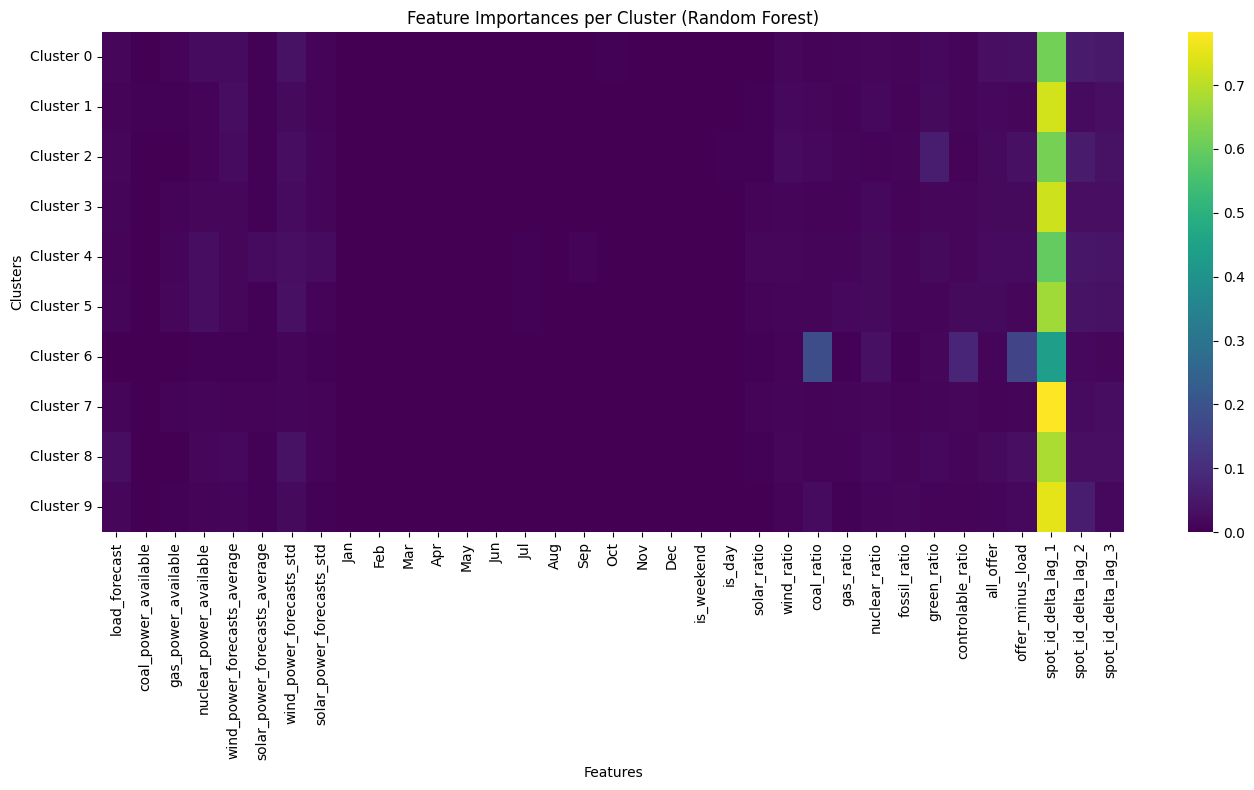

In [18]:
# To store feature importances
feature_names = df_clustered_train_list[0].columns
cluster_importances = pd.DataFrame(index=feature_names)

for i in range(n_clusters):
    X_train = df_clustered_train_list[i]
    y_train = y_train_df[y_train_df.index.isin(X_train.index)]
    
    # Fit Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    
    # Save feature importances
    importances = rf.feature_importances_
    cluster_importances[f'Cluster {i}'] = importances

# Transpose for heatmap (features in rows, clusters in columns)
cluster_importances = cluster_importances.T

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_importances, cmap='viridis', annot=False, xticklabels=True, yticklabels=True)
plt.title('Feature Importances per Cluster (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.tight_layout()
plt.show()

# Global feature ranking

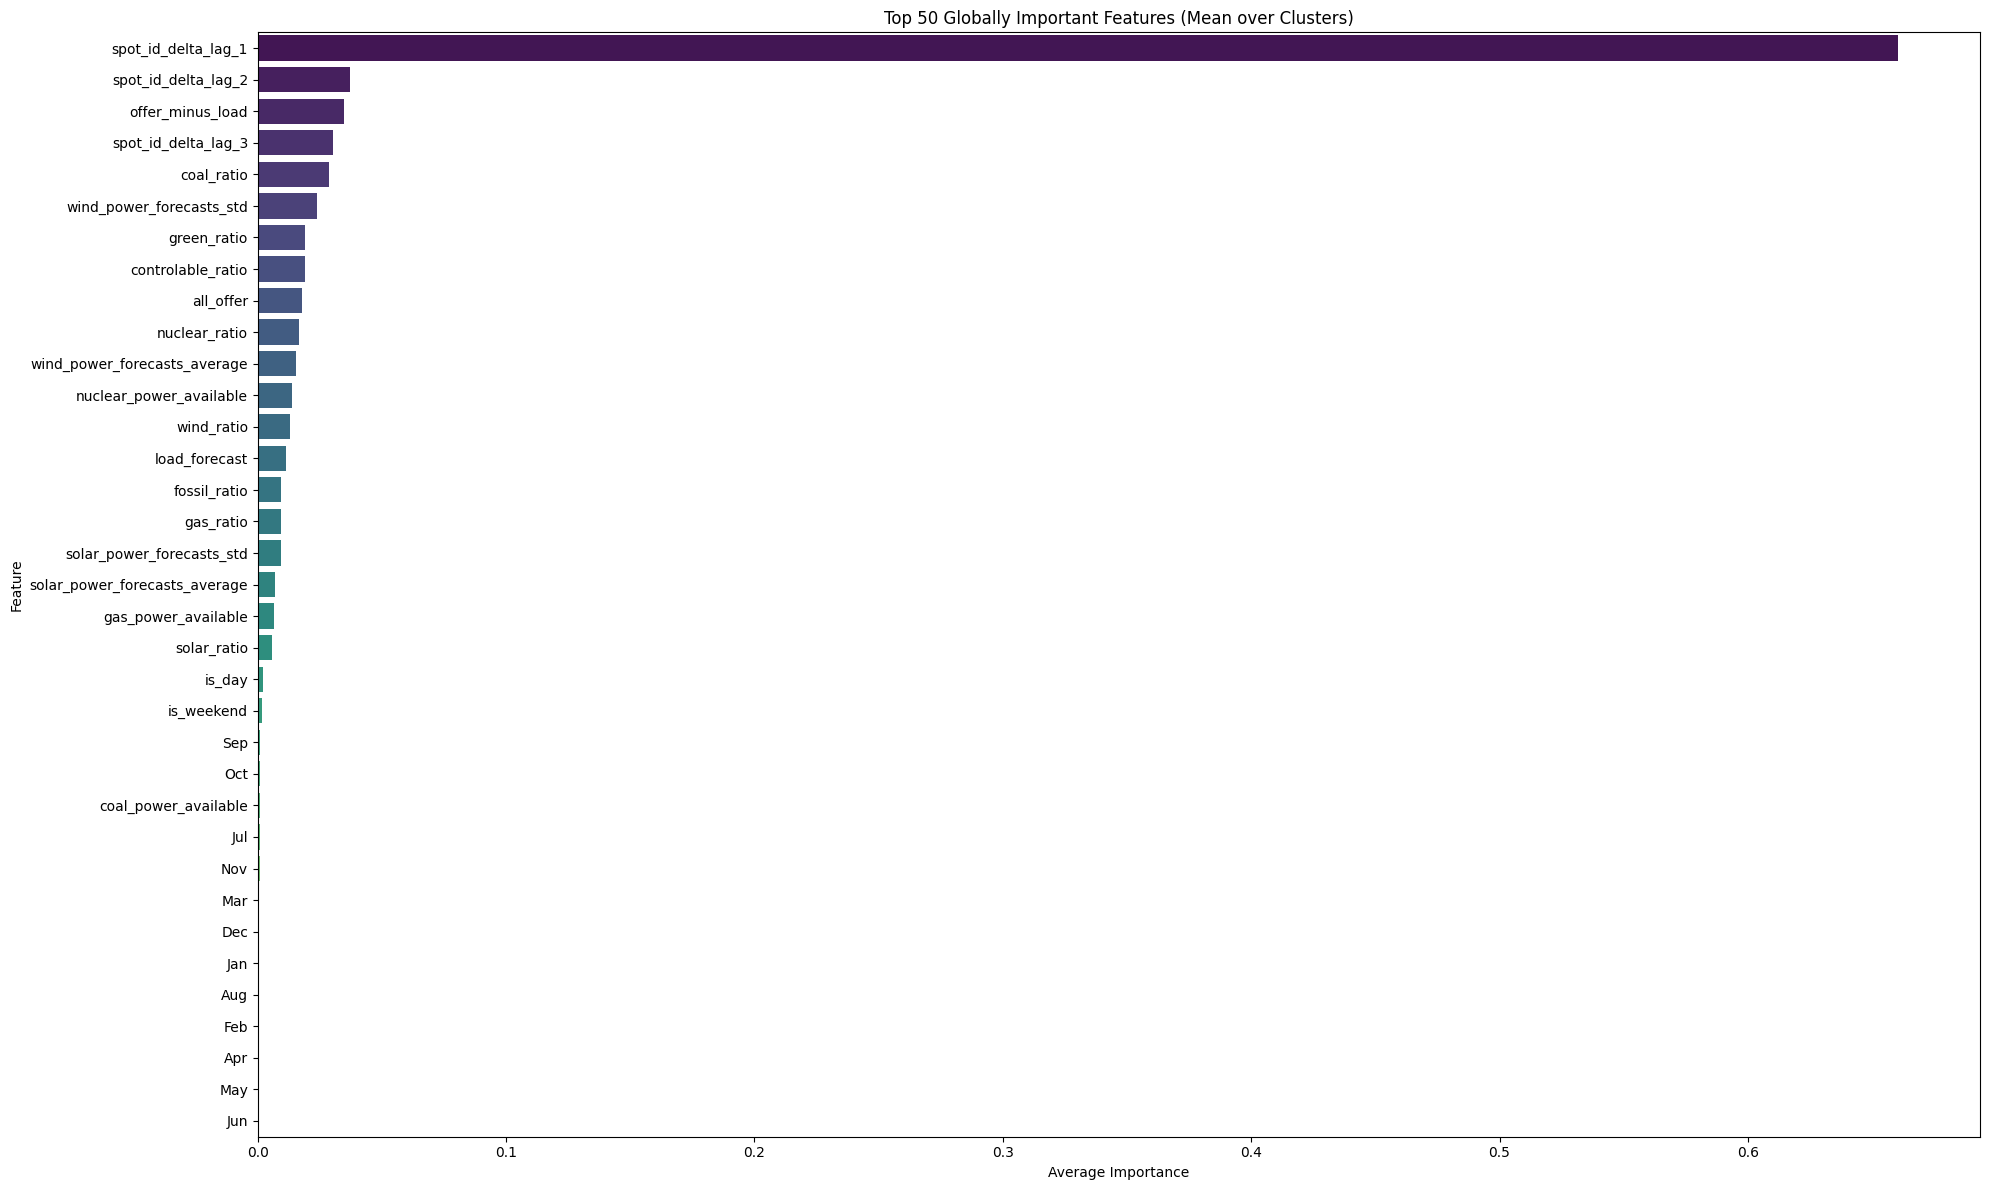

In [19]:
# Global average importances
global_importance = cluster_importances.mean(axis=0).sort_values(ascending=False)

# Plot top N global features
top_n = 50
plt.figure(figsize=(20, 12))
sns.barplot(x=global_importance.values[:top_n], y=global_importance.index[:top_n], palette='viridis')
plt.title(f'Top {top_n} Globally Important Features (Mean over Clusters)')
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Importance Variability Across Clusters

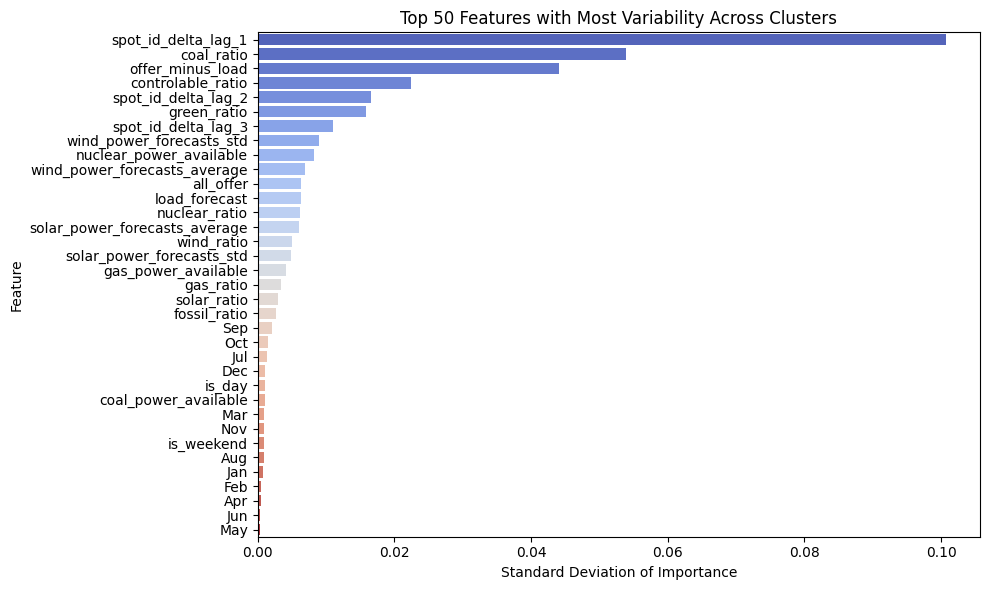

In [20]:
# Standard deviation of feature importances across clusters
importance_std = cluster_importances.std(axis=0).sort_values(ascending=False)

# Plot top N most variable features
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_std.values[:top_n], y=importance_std.index[:top_n], palette='coolwarm')
plt.title(f'Top {top_n} Features with Most Variability Across Clusters')
plt.xlabel('Standard Deviation of Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

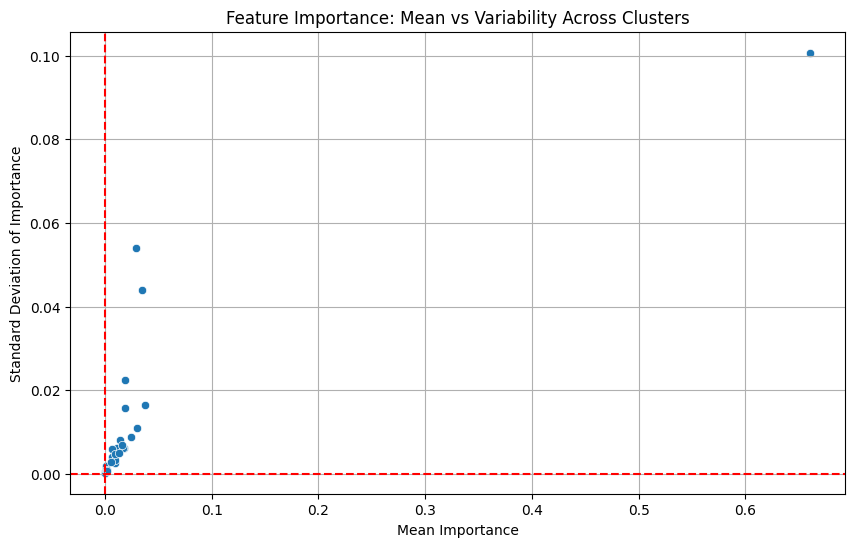

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=global_importance, y=importance_std)
plt.title("Feature Importance: Mean vs Variability Across Clusters")
plt.xlabel("Mean Importance")
plt.ylabel("Standard Deviation of Importance")
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid()
plt.show()